In [ ]:
import tensorflow as tf
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import ensemble
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, ParameterGrid

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
device = '/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'

In [ ]:
x_train = np.load('/content/gdrive/My Drive/Assignment 3/x_train.npy')
print(f'Shape of training data: {x_train.shape}')

x_test = np.load('/content/gdrive/My Drive/Assignment 3/x_test.npy')
print(f'Shape of test data: {x_test.shape}')

y_train = np.load('/content/gdrive/My Drive/Assignment 3/y_train.npy')
print(f'Shape of labels/targets: {y_train.shape}')

scaler = StandardScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

Shape of training data: (20000, 48)
Shape of test data: (5000, 48)
Shape of labels/targets: (20000,)


In [ ]:
x_train_copy = x_train
y_train_copy = y_train

num_ensembles = 3
samples_per_ensemble = x_train_copy.shape[0] // num_ensembles

np.random.seed(42)

datasets = {}

for i in range(1, 4):
    indices = np.random.choice(x_train_copy.shape[0], samples_per_ensemble, replace=False)

    X_subset = x_train_copy[indices]
    y_subset = y_train_copy[indices]

    datasets[f'X_{i}'] = X_subset
    datasets[f'y_{i}'] = y_subset

    x_train_copy = np.delete(x_train_copy, indices, axis=0)
    y_train_copy = np.delete(y_train_copy, indices, axis=0)

In [ ]:
for i in range(1, 4):
    X = datasets[f'X_{i}']
    y = datasets[f'y_{i}']
    print(f"Shape of X_{i}: {X.shape}")
    print(f"Shape of y_{i}: {y.shape}")

Shape of X_1: (6666, 48)
Shape of y_1: (6666,)
Shape of X_2: (6666, 48)
Shape of y_2: (6666,)
Shape of X_3: (6666, 48)
Shape of y_3: (6666,)


## Hyperparameters for 3 Models:

<br>

**Model 1: FFNN**

**Model 2: Boosting**

**Model 3: Random Forest**

<br>

Each model is based on 1/3 of the training data.



**Model 1 (Hyperparameters search):**

In [ ]:
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(48,)),
    tf.keras.layers.Dense(96, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(48, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    #tf.keras.layers.Dropout(0.35),
    tf.keras.layers.Dense(1, activation='linear'),
])

model_1.compile(
    loss='mse',
    optimizer=tf.keras.optimizers.experimental.Adam(0.0001),
    metrics=['mae'],
)

In [ ]:
X_1 = datasets['X_1']
y_1 = datasets['y_1']

callback = tf.keras.callbacks.EarlyStopping(monitor='val_mae',
                                            patience=30,
                                            restore_best_weights=True)

model_1.summary()

history_1 = model_1.fit(
    X_1,
    y_1,
    epochs=10,
    verbose=1,
    validation_split=0.2,
    callbacks=callback
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 48)                0         
                                                                 
 dense_3 (Dense)             (None, 96)                4704      
                                                                 
 batch_normalization_2 (Bat  (None, 96)                384       
 chNormalization)                                                
                                                                 
 dense_4 (Dense)             (None, 48)                4656      
                                                                 
 batch_normalization_3 (Bat  (None, 48)                192       
 chNormalization)                                                
                                                                 
 dense_5 (Dense)             (None, 1)                

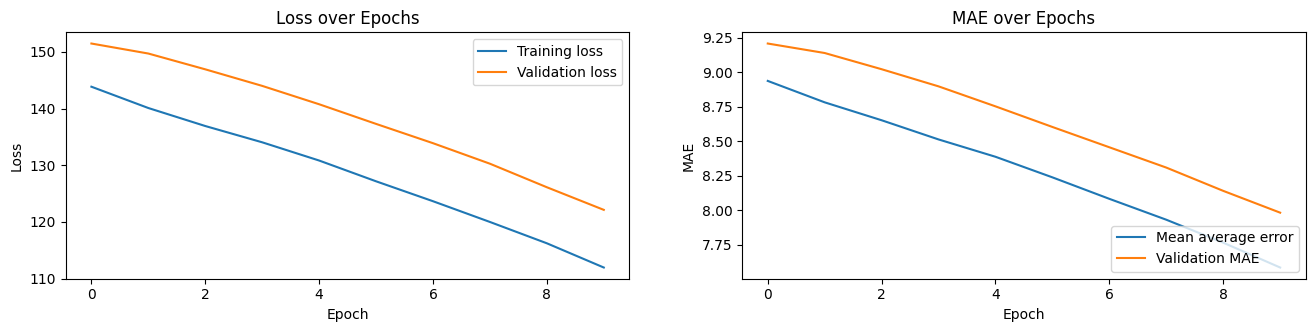

In [ ]:
history_x = history_1
history_y = history_1

fig = plt.figure(figsize=plt.figaspect(0.2))

ax = fig.add_subplot(1, 2, 1)
ax.plot(history_x.history['loss'], label='Training loss')
ax.plot(history_y.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Loss over Epochs')
plt.legend(loc='upper right')

ax = fig.add_subplot(1, 2, 2)
ax.plot(history_x.history['mae'], label='Mean average error')
ax.plot(history_y.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title(f'MAE over Epochs')
plt.legend(loc='lower right')

plt.show()

**Model 2 (Hyperparameters search):**

In [ ]:
X_2 = datasets['X_2']
y_2 = datasets['y_2']

X_train_2, X_val_2, y_train_2, y_val_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=42)

param_grid = ParameterGrid({
    'n_estimators': [250, 500, 1000],
    'min_samples_split': [10, 25, 250],
    'min_samples_leaf': [10, 25, 250],
    'learning_rate': [0.015, 0.1, 0.25]
    })

score_ = 0
params_ = None

for params in param_grid:
  gbt_current = ensemble.GradientBoostingRegressor(
                n_estimators=params['n_estimators'],
                min_samples_split=params['min_samples_split'],
                min_samples_leaf=params['min_samples_leaf'],
                learning_rate=params['learning_rate'],
                )
  gbt_current.fit(X_train_2, y_train_2)
  y_val_hat = gbt_current.predict(X_val_2)
  val_MAE = mean_absolute_error(y_val_hat, y_val_2)
  if val_MAE > score_:
    score_ = val_MAE
    params_ = params

KeyboardInterrupt: 

In [ ]:
print(f"For GB the best hyperparameters are: {params_}, the mean average error of the model is: {val_MAE}")

For GB the best hyperparameters are: {'learning_rate': 0.5, 'min_samples_leaf': 10, 'min_samples_split': 250, 'n_estimators': 8000}, the mean average error of the model is: 8.066256368107819


**Model 3 (Hyperparameters search):**

In [ ]:
X_3 = datasets['X_3']
y_3 = datasets['y_3']

X_train_3, X_val_3, y_train_3, y_val_3 = train_test_split(X_3, y_3, test_size=0.2, random_state=42)

param_grid = ParameterGrid({
    'n_estimators': [250, 500, 1000, 2000, 4000, 8000],
    'min_samples_split': [10, 20, 50, 100, 250],
    'min_samples_leaf': [10, 20, 50, 100, 250],
    'max_depth': [None, 30, 20, 15, 10, 3, 2],
    'max_features': ['sqrt', 'log2', 20, 10]
    })

score_ = 0
params_ = None
for params in param_grid:
  rf_current = ensemble.RandomForestRegressor(
                n_estimators=params['n_estimators'],
                min_samples_split=params['min_samples_split'],
                min_samples_leaf=params['min_samples_leaf'],
                max_depth=params['max_depth'],
                max_features=params['max_features'],
                )
  rf_current.fit(X_train_3, y_train_3)
  y_val_hat = rf_current.predict(X_val_3)
  val_MAE = mean_absolute_error(y_val_hat, y_val_3)
  if val_MAE > score_:
    score_ = val_MAE
    params_ = params

KeyboardInterrupt: 

In [ ]:
print(f"For RF the best hyperparameters are: {params_}, the mean average error of the model is: {val_MAE}")

For RF the best hyperparameters are: {'max_depth': None, 'max_features': 20, 'min_samples_leaf': 10, 'min_samples_split': 20, 'n_estimators': 500}, the mean average error of the model is: 6.561423749354163


## Train the models with the chosen hyperparameters, and predict on the test data for kaggle upload.

**Dataframe for ensemble:**

In [ ]:
df_ensemble = pd.DataFrame()

**Model 1 (FFNN) predictions:**

In [ ]:
history_1 = model_1.fit(
    x_train,
    y_train,
    epochs=10000,
    verbose=1,
    validation_split=0.2,
    callbacks=callback
)

y_test_hat_1 = model_1.predict(x_test)

df_ensemble['model_1'] = y_test_hat_1.reshape(-1)

Epoch 1/10000
500/500 [==============================] - 3s 5ms/step - loss: 142.5507 - mae: 8.9124 - val_loss: 146.1193 - val_mae: 9.0125
Epoch 2/10000
500/500 [==============================] - 3s 5ms/step - loss: 142.3622 - mae: 8.8955 - val_loss: 145.7676 - val_mae: 8.9969
Epoch 3/10000
500/500 [==============================] - 4s 8ms/step - loss: 141.9073 - mae: 8.8776 - val_loss: 145.4147 - val_mae: 8.9798
Epoch 4/10000
500/500 [==============================] - 3s 6ms/step - loss: 141.9206 - mae: 8.8739 - val_loss: 145.7307 - val_mae: 8.9929
Epoch 5/10000
500/500 [==============================] - 3s 5ms/step - loss: 141.4021 - mae: 8.8546 - val_loss: 145.1270 - val_mae: 8.9660
Epoch 6/10000
500/500 [==============================] - 2s 5ms/step - loss: 141.4425 - mae: 8.8488 - val_loss: 144.4010 - val_mae: 8.9327
Epoch 7/10000
500/500 [==============================] - 3s 5ms/step - loss: 141.0882 - mae: 8.8381 - val_loss: 144.7233 - val_mae: 8.9466
Epoch 8/10000
500/500 [====

**Model 2 (Boosting) predictions:**

In [ ]:
model_2 = ensemble.GradientBoostingRegressor(
                n_estimators=8000,
                min_samples_split=250,
                min_samples_leaf=10,
                learning_rate=0.5,
                )

model_2.fit(x_train, y_train)
y_test_hat_2 = model_2.predict(x_test)

df_ensemble['model_2'] = y_test_hat_2

**Model 3 (Random Forest) predictions:**

In [ ]:
model_3 = ensemble.RandomForestRegressor(
                n_estimators=500,
                min_samples_split=20,
                min_samples_leaf=10,
                max_depth=None,
                max_features=20,
                )

model_3.fit(x_train, y_train)
y_test_hat_3 = model_3.predict(x_test)

df_ensemble['model_3'] = y_test_hat_3

### The average prediction over the three models:

In [ ]:
df_ensemble['average'] = df_ensemble.mean(axis=1)

print(df_ensemble)

        model_1    model_2    model_3    average
0      6.129264  10.422166   8.078810   8.210080
1      5.923067   5.080645   9.020399   6.674703
2      6.377745   3.161189   8.518992   6.019309
3      5.546168   5.883326   8.213910   6.547801
4     10.324500  21.553088  10.171601  14.016396
...         ...        ...        ...        ...
4995   7.265414   0.131600   9.337331   5.578115
4996   6.472367  19.041145  10.627036  12.046849
4997   5.628162   7.331959   7.751156   6.903759
4998   6.155091  16.110981   8.895622  10.387231
4999   7.124936   3.606870   9.545064   6.758956

[5000 rows x 4 columns]


In [ ]:
df_ensemble = pd.DataFrame({
    'Id': range(len(df_ensemble)),
    'Predicted': df_ensemble['model_3'].values,
})

path_on_drive = '/content/gdrive/My Drive/Assignment 3/pred.csv'
df_ensemble.to_csv(path_on_drive, index=False)

KeyError: ignored

In [ ]:
y_test_hat_1 = model_1.predict(x_test)

df_ensemble['model_1'] = y_test_hat_1.reshape(-1)


y_test_hat_2 = model_2.predict(x_test)

df_ensemble['model_2'] = y_test_hat_2


y_test_hat_3 = model_3.predict(x_test)

df_ensemble['model_3'] = y_test_hat_3

157/157 [==============================] - 0s 3ms/step


In [ ]:
df_ensemble = pd.DataFrame({
    'Id': range(len(df_ensemble)),
    'Predicted': df_ensemble['model_1'].values,
})

path_on_drive = '/content/gdrive/My Drive/Assignment 3/pred.csv'
df_ensemble.to_csv(path_on_drive, index=False)

KeyError: ignored

**Model 1: 8.89**

**Model 2: 9.98**

**Model 3: 8.463**

Train model 1 and 2.

Make predictions with the new hyperparameters...

